In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
import pathlib
from sklearn.model_selection import train_test_split
import tensorflow_model_optimization as tfmot

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS =3 
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

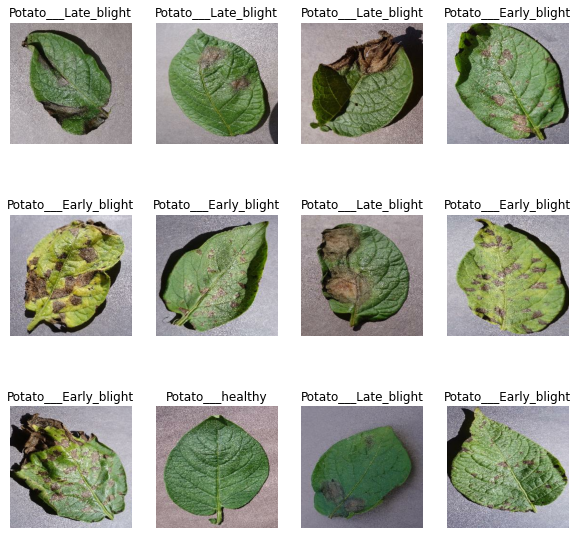

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
train_ds = dataset.take(54)
len(train_ds)

54

In [7]:
test_ds1 = dataset.skip(54)
len(test_ds1)

14

In [8]:
val_ds = test_ds1.take(6)
test_ds = test_ds1.skip(6)

In [9]:
def get_dataset_prepration(ds, train_split= 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_prepration(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential(
  [
    
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.3),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  ]
)

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [20]:
history = model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_ds)

Epoch 1/20
54/54 [==============================] - 113s 2s/step - loss: 0.9513 - accuracy: 0.4734 - val_loss: 0.8736 - val_accuracy: 0.7344
Epoch 2/20
54/54 [==============================] - 105s 2s/step - loss: 0.8369 - accuracy: 0.5457 - val_loss: 0.6723 - val_accuracy: 0.7188
Epoch 3/20
54/54 [==============================] - 108s 2s/step - loss: 0.7105 - accuracy: 0.7106 - val_loss: 0.4989 - val_accuracy: 0.8229
Epoch 4/20
54/54 [==============================] - 115s 2s/step - loss: 0.6491 - accuracy: 0.7257 - val_loss: 0.4131 - val_accuracy: 0.8333
Epoch 5/20
54/54 [==============================] - 105s 2s/step - loss: 0.4904 - accuracy: 0.8056 - val_loss: 0.5098 - val_accuracy: 0.7917
Epoch 6/20
54/54 [==============================] - 113s 2s/step - loss: 0.4471 - accuracy: 0.8235 - val_loss: 0.2664 - val_accuracy: 0.8906
Epoch 7/20
54/54 [==============================] - 154s 3s/step - loss: 0.3911 - accuracy: 0.8380 - val_loss: 0.1870 - val_accuracy: 0.9375
Epoch 8/20
54

In [21]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 359ms/step - loss: 0.2750 - accuracy: 0.8984


[0.274973601102829, 0.8984375]

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 451ms/step
predicted label: Potato___Late_blight


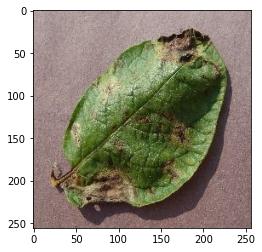

In [23]:
for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label:", class_names[batch_prediction[0].argmax()])

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    batch_prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(batch_prediction[0])]
    confidence = round(100*(np.max(batch_prediction[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 38ms/step


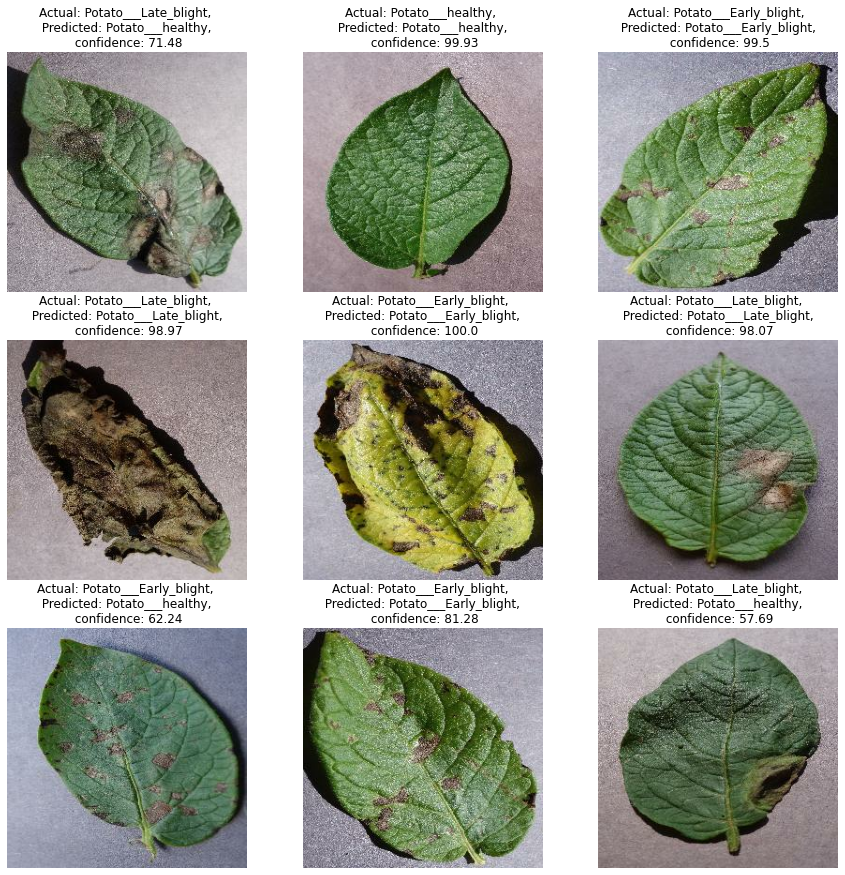

In [25]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n confidence: {confidence}")
        
        plt.axis("off")
        

In [26]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models")+[0]]) + 1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/6\assets


INFO:tensorflow:Assets written to: ../saved_models/6\assets


In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmpn0i3yarx\assets


INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmpn0i3yarx\assets


In [28]:
with open("tflite_quant_model.tflite", "wb") as f:
    f.write(tflite_model)

## Model pre trained Quantization

In [29]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [30]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 254, 254, 32)     963       
 erV2)                                                           
                                                                 
 quant_max_pooling2d (Quanti  (None, 127, 127, 32)     1         
 zeWrapperV2)                                                    
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 125, 125, 64)     18627     
 pperV2)                                                         
                                                      

In [31]:
quant_aware_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [32]:
quant_aware_model.fit(train_ds, epochs = EPOCHS, batch_size = BATCH_SIZE, verbose = 1, validation_data = val_ds)

Epoch 1/20
54/54 [==============================] - 96s 2s/step - loss: 0.1649 - accuracy: 0.9352 - val_loss: 0.1113 - val_accuracy: 0.9375
Epoch 2/20
54/54 [==============================] - 98s 2s/step - loss: 0.1085 - accuracy: 0.9578 - val_loss: 0.2975 - val_accuracy: 0.9010
Epoch 3/20
54/54 [==============================] - 95s 2s/step - loss: 0.1061 - accuracy: 0.9653 - val_loss: 0.2859 - val_accuracy: 0.9115
Epoch 4/20
54/54 [==============================] - 101s 2s/step - loss: 0.1047 - accuracy: 0.9601 - val_loss: 0.0924 - val_accuracy: 0.9583
Epoch 5/20
54/54 [==============================] - 100s 2s/step - loss: 0.0829 - accuracy: 0.9734 - val_loss: 0.1934 - val_accuracy: 0.9271
Epoch 6/20
54/54 [==============================] - 100s 2s/step - loss: 0.0908 - accuracy: 0.9699 - val_loss: 0.1053 - val_accuracy: 0.9427
Epoch 7/20
54/54 [==============================] - 102s 2s/step - loss: 0.0619 - accuracy: 0.9797 - val_loss: 0.2890 - val_accuracy: 0.9219
Epoch 8/20
54/54

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()


with open("tflite_qaware_model_potatodisease.tflite", 'wb') as f:
    f.write(tflite_qaware_model)

INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmp0nla4jb3\assets


INFO:tensorflow:Assets written to: C:\Users\Abhishek\AppData\Local\Temp\tmp0nla4jb3\assets
C:\Users\Abhishek\anaconda3\envs\env1\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [34]:
MODEL = tf.keras.models.load_model("../saved_models/1")

In [35]:
MODEL